# Системи Data Science. Лабораторна робота №1.

## Назва: Прогнозування вартості автомобілів

## Виконав: Кулик Костянтин, група КМ-81.

# 1.1. Розуміння бізнесу - розуміння даних

## 1.1.1. Область дослідження

Було вирішено дослідити найдорожчі автомобілі на ринку США. Метою цього дослідження є встановлення сучасних ринкових тенденцій впливу різних характеристик на ціну автомобіля та знаходження залежностей між цими характеристиками. Основною задачею є розробка системи, що буде прогнозувати ціну автомобіля.

## 1.1.2. Збір даних з інтернет-ресурсів

Придатний до використання датасет був знайдений на ресурсі Kaggle. Цей notebook був створений за допомогою сервісу `Kaggle Notebook`, що дозволяє зручно працювати з обраними датасетами.

Визначимо, які файли доступні для використання:

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Доступні два файли - датасет у csv-форматі та Excel-таблиця з описом полів. Ми будемо використовувати лише перший.

## 1.1.3. Збереження даних в структурі pandas.DataFrame

Завантажимо csv-файл та збережемо отриману структуру DataFrame:

In [ ]:
import pandas as pd

data = pd.read_csv("/kaggle/input/car-price-prediction/CarPrice_Assignment.csv")

Виведемо декілька записів:

In [ ]:
data.head(10)

## 1.1.4. Опис даних

Виведемо дані про загальну кількість записів та колонок, а також про типи даних кожного параметру:

In [ ]:
data.info()

Бачимо, що багато параметрів мають тип `object`, для подальшого аналізу деякі з них потрібно буде перетворити на категоріальні.

# 1.2. Підготовка даних

## 1.2.1. Видалення дублікатів, аномалій та усунення некоректних значень

Почнемо підготовку з перевірки наявності дублікатів:

In [ ]:
len(data[data.car_ID.duplicated(keep=False)])

Дублікатів немає.

Перевіримо на некоректні значення:

In [ ]:
data.isnull().sum()

Некоректних значень також немає.

Перевіримо на наявність аномалій:

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.displot(data.price)
plt.title("Гістограма розподілу ціни")
plt.show()

Дані не містять аномалій.

## 1.2.2. Приведення даних до стандартних форматів.

Перетворимо всі колонки типу `object` на `category`, а `CarName` - на `string`.

In [ ]:
data.CarName = data.CarName.astype("string")
for c in ["fueltype", "aspiration", "doornumber", "carbody", "drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"]:
    data[c] = data[c].astype("category")

Повторно виведемо дані про колонки:

In [ ]:
data.info()

## 1.2.3. Розвідувальний аналіз даних

Виведемо основні характеристики числових параметрів:

In [ ]:
data.describe()

Побудуємо декілька ілюстраційних графіків.

Спочатку покажемо розподіл типів кузова серед автомобілів:

In [ ]:
carbody = data.carbody.value_counts()
plt.figure(figsize=(5, 5))
plt.pie(carbody.values, labels=carbody.index, autopct="%1.f%%")
plt.title("Діаграма розподілу типів кузова")
plt.show()

Тепер покажемо середню ціну в залежності від типу кузова:

In [ ]:
def get_avg_cat_price(col):
    cv = dict()
    for cat in data[col].cat.categories:
        cv[cat] = data[data[col] == cat].price.mean()
    return cv

plt.bar(*zip(*get_avg_cat_price("carbody").items()))
plt.title("Середня ціна")
plt.xlabel("Тип кузова")
plt.ylabel("Ціна")
plt.show()

Та в залежності від типу палива, кількості дверей та типу привода:

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].bar(*zip(*get_avg_cat_price("fueltype").items()))
axs[0].set_xlabel("Тип палива")
axs[1].bar(*zip(*get_avg_cat_price("doornumber").items()))
axs[1].set_xlabel("Кількість дверей")
axs[2].bar(*zip(*get_avg_cat_price("drivewheel").items()))
axs[2].set_xlabel("Тип приводу")
fig.suptitle("Середня ціна")
fig.supylabel("ціна")
plt.tight_layout()
plt.show()

З графіків видно, що найдорожчим автомобілям частіше притаманні наступні характеристики:

* Задній привод
* Тип кузова - кабріолет чи хардтоп
* Тип палива - дизель

Також спостерігаються деякі очевидні залежності - наприклад, чим більше автомобіль, тим він дорожче:

In [ ]:
sns.regplot(x="enginesize", y="price", data=data)
plt.show()

## 1.2.4. Конструювання ознак

Створимо на основі існуючих колонок наступні характеристики:

* `carbody` - `onehot encoding`
* `fueltype` - `ordinal encoding`
* `aspiration` - `ordinal encoding`
* `doornumber` - `ordinal encoding`
* `drivewheel` - `ordinal encoding`
* `enginelocation` - `ordinal encoding`
* `enginetype` - `ordinal encoding`
* `cylindernumber` - `ordinal encoding`
* `fuelsystem` - `ordinal encoding`

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

data_f = pd.get_dummies(data, columns=["carbody"])
cat_f = ["fueltype", "aspiration", "doornumber", "drivewheel", "enginelocation", "enginetype", "cylindernumber", "fuelsystem"]
data_f[cat_f] = OrdinalEncoder().fit_transform(data[cat_f]).astype("int")

Видалимо колонки `car_ID` та `CarName`:

In [ ]:
data_f.drop(["car_ID", "CarName"], axis=1, inplace=True)

Виведемо дані про характеристики:

In [ ]:
data_f.info()

Дані повністю підготовані.

Виведемо кореляційну матрицю та функцію розподілу модуля її коефіцієнтів:

In [ ]:
import numpy as np

def calc_corr(data):
    m = data.corr()
    mv = m.where(np.triu(np.ones(m.shape), k=1).astype("bool")).stack().reset_index()
    return m, np.absolute(mv[mv.columns[-1]])

corr_matrix, corr_coeffs = calc_corr(data_f)
plt.figure(figsize=(20,20))
sns.heatmap(data_f.corr(), square=True, annot=True)
plt.title("Кореляційна матриця")
plt.show()
sns.kdeplot(corr_coeffs, cumulative=True)
plt.title("Розподіл модуля кореляційних коефіцієнтів")
plt.show()

Більша частина кореляційних коефіцієнтів за модулем не перевищує `0.15`, отже, загальна зв'язність між характеристиками не є високою.

Можна помітити, що ціна автомобіля, його розміри, маса, привід, потужніть двигуна та пробіг сильно корельовані між собою.

Також помітний зв'язок між:

* Паливними параметрами двигуна (в силу конструктивних причин)
* Безпечністю автомобіля та кількістю дверей

## 1.2.5. Розбиття даних на тренувальні та тестові набори

In [ ]:
from sklearn.model_selection import train_test_split

data_f_train, data_f_test = train_test_split(data_f, test_size=0.33)
print(f"Розмірність тренувальних даних: {data_f_train.shape}")
print(f"Розмірність тестових даних: {data_f_test.shape}")

## 1.2.6. Бізнес-профіль Еріксона-Пенкера

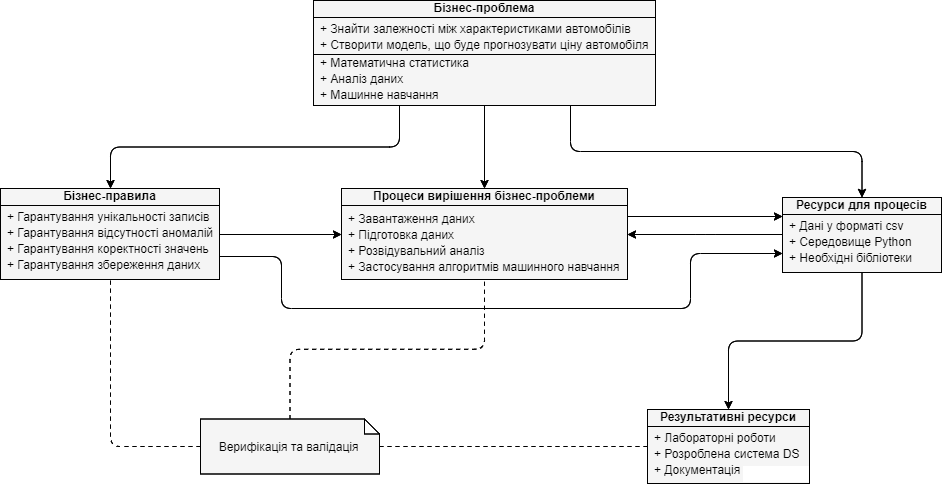

# 1.3. Верифікація

Основною ціллю лабораторної роботи була підготовка даних для вирішення конкретної задачі. Необхідно було поставити цю задачу, визначивши предметну область, та дослідити в її рамках певні довільно вибрані дані, знайдені на відкритих ресурсах.

* Предметна область - ринок автомобілів в США.
* Основна задача - знайти залежності між характеристиками автомобілів та підготувати дані для прогнозування ціни.

Придатні до використання дані були завантажені з ресурсу Kaggle, їхня структура була описана.

Була проведена підготовка даних до аналізу:
* Перевірка на наявність дублікатів, аномалій та некоректних значень
* Приведення даних до стандартних форматів

Був проведений розвідувальний аналіз даних з виведенням відповідних графіків. Категорілальні ознаки були закодовані, непотрібні колонки - видалені.

Дані були розбито на тренувальний та тестовий набори у співвідношенні `67:33`.

Також були задокументовані класи бізнес-профілю Еріксона-Пенкера.

Умови лабораторної роботи були виконані, отже, верифікація пройдена успішно.

# 1.4. Валідація

Проаналізувавши датасет, приходимо до висновку, що дані є цілком коректними. Були отримані результати, що являються цілком логічними та справедливими для реального світу. Наприклад, простежується зв'язок між конструктивно залежними параметрами двигуна, між розмірами та масою автомобіля тощо.

Головною ціллю дослідження є розробка моделі, що буде передбачувати ринкову ціну автомобіля за його характеристиками. Незважаючи на помітний виробничо обумовлений вплив на ціну наведених у датасеті характеристик, для повної картини необхідно додатково досліджувати широкі класи маркетингових даних. Тому таке дослідження, будучи обмеженим в джерелах та класах даних, може дати неточні або взагалі невірні прогнози.

# Висновки

За результатами верифікації можемо прийти до висновку, що робота відповідає заданим вимогам.

В процесі виконання роботи були використані базові можливості наступних інструментів роботи з даними:

* pandas
* matplotlib
* seaborn
* numpy
* sklearn

Були пройдені основні етапи конструювання системи Data Science:

* 1. Збір сирих даних
* 2. Очистка та первинна підготовка даних
* 3. Розвідувальний аналіз даних
* 4. Розбиття даних на тренувальні та тестові набори
* 5. Верифікація та валідація

Дані підготовлені до наступного етапу розробки системи - застосування алгоритмів Machine Learning для прогнозування ціни автомобілів.